# Week 4 NLP Disaster Tweets Kaggle Mini-Project

## Description

This notebook outlines the analysis and model building procedure for the Kaggle competition found at https://www.kaggle.com/c/nlp-getting-started/overview.

Each sample in the train and test set has the following information:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

Link to Github: https://github.com/WyattHough/msds/blob/main/deep_learning/Week%204/Week4.ipynb

In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report, precision_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

## Exploratory Data Analysis

In [25]:
df = pd.read_csv('nlp-getting-started/train.csv')
print(df.head())
print(df.shape)

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
(7613, 5)


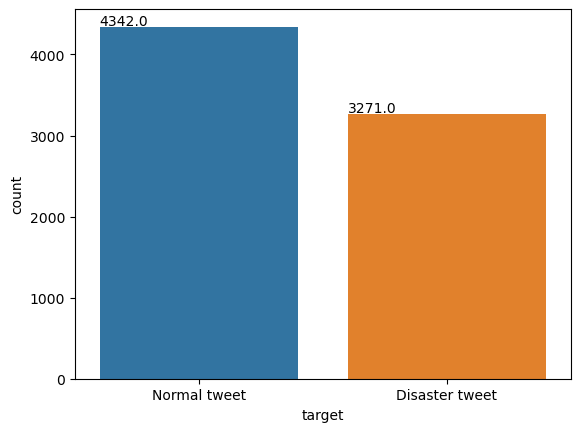

In [26]:
s=sns.countplot(x="target", data=df)
for p in s.patches:
    s.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    s.set_xticklabels(['Normal tweet','Disaster tweet']);

In [27]:
nltk.download('stopwords')

stopword = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stopword]))
df[['text','stopwords', 'target']].head()

[nltk_data] Downloading package stopwords to /home/wyatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords,target
0,Our Deeds are the Reason of this #earthquake M...,5,1
1,Forest fire near La Ronge Sask. Canada,0,1
2,All residents asked to 'shelter in place' are ...,9,1
3,"13,000 people receive #wildfires evacuation or...",1,1
4,Just got sent this photo from Ruby #Alaska as ...,6,1


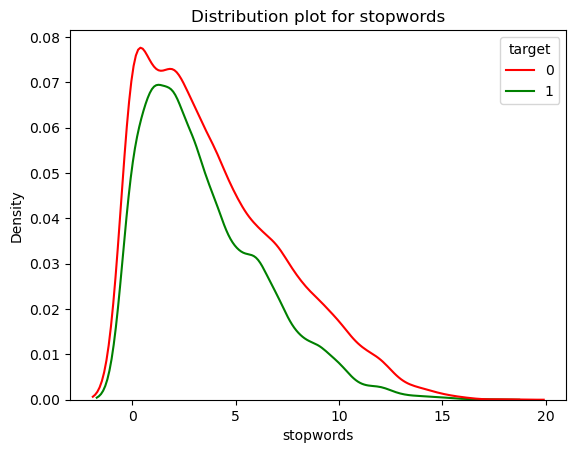

In [17]:
sns.kdeplot(x=df['stopwords'], hue=df['target'], 
            palette=['red', 'green']).set_title('Distribution plot for stopwords');

In [28]:
stemmer = PorterStemmer()

def tweet_to_words(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # Remove URLs containing 'http'
    letters_only = re.sub('[^a-zA-Z0-9]', ' ', tweet)
    letters_only = re.sub(r'[0-9]+', '', letters_only)
    words = letters_only.lower().split()
    stopwords_list = set(stopwords.words('english'))
    stopwords_list.add('http')  # Add 'http' to the stopwords list
    meaningful_words = [stemmer.stem(word) for word in words if word not in stopwords_list]
    return " ".join([meaningful_words for meaningful_words in meaningful_words if len(meaningful_words) > 2])

df['clean_text'] = df['text'].apply(lambda x: tweet_to_words(x))
df.head()

,id,keyword,location,text,target,stopwords,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,5,deed reason earthquak may allah forgiv
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,forest fire near rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,9,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,6,got sent photo rubi alaska smoke wildfir pour ...


In [29]:
pos_corpus = []
neg_corpus=[]

for txt in df[df['target'] == 1]['clean_text'].tolist():
    for word in txt.split():
        pos_corpus.append(word)

for txt in df[df['target'] == 0]['clean_text'].tolist():
    for word in txt.split():
        neg_corpus.append(word)

print(len(pos_corpus), len(neg_corpus))

30080 36279


In [54]:
X= df['clean_text']
y = df['target']

# Split data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [57]:
tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 50
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


## Model and Results

In [51]:
num_words = len(tokenizer.word_index) + 1

model=Sequential()

embedding=Embedding(num_words,100,input_length=50,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1124100   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,166,405
Trainable params: 42,305
Non-trainable params: 1,124,100
_________________________________________________________________


In [60]:
history=model.fit(X_train,y_train,batch_size=4,epochs=5,validation_data=(X_test,y_test),verbose=2)

Epoch 1/5
1523/1523 - 197s - loss: 0.6880 - accuracy: 0.5675 - val_loss: 0.6863 - val_accuracy: 0.5620 - 197s/epoch - 129ms/step
Epoch 2/5
1523/1523 - 177s - loss: 0.6837 - accuracy: 0.5724 - val_loss: 0.6854 - val_accuracy: 0.5620 - 177s/epoch - 116ms/step
Epoch 3/5
1523/1523 - 152s - loss: 0.6830 - accuracy: 0.5724 - val_loss: 0.6855 - val_accuracy: 0.5620 - 152s/epoch - 100ms/step
Epoch 4/5
1523/1523 - 154s - loss: 0.6827 - accuracy: 0.5724 - val_loss: 0.6856 - val_accuracy: 0.5620 - 154s/epoch - 101ms/step
Epoch 5/5
1523/1523 - 193s - loss: 0.6831 - accuracy: 0.5724 - val_loss: 0.6855 - val_accuracy: 0.5620 - 193s/epoch - 127ms/step


In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)
f1 = f1_score(y_test, y_pred)

print("F1 score:", f1)

In [62]:
test = pd.read_csv('nlp-getting-started/test.csv')
print(test.head())

x_test = test['text']
x_test = tokenizer.texts_to_sequences(x_test)
maxlen = 50
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
y_pred = model.predict(x_test)
y_pred

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
102/102 [==============================] - 4s 37ms/step


array([[0.42975235],
       [0.42980394],
       [0.4302454 ],
       ...,
       [0.42980066],
       [0.42981815],
       [0.42979372]], dtype=float32)

In [64]:
y_pred.shape

(3263, 1)

In [65]:
# Create a DataFrame for the submission file
y_pred=np.round(y_pred).astype(int).reshape(3263)
submission = pd.DataFrame({'id': test['id'], 'target': y_pred})

# Save the submission file
submission.to_csv('submission.csv', index=False)

## Conclusion

The submission earned a score of 0.57033 on kaggle. This score was not very good for preformance, just a little better than guessing. In future iterations I would concentrate on experimenting with more layers and adding dropout regularization to prevent overfitting.